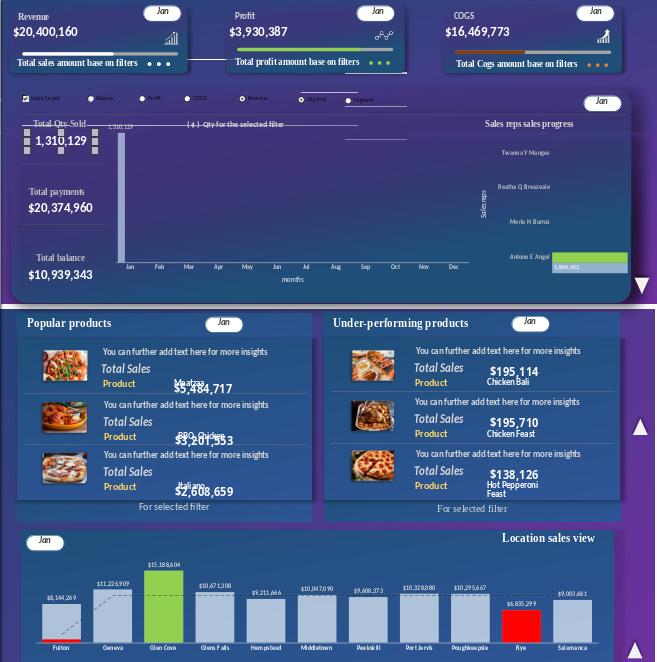

### Company made Progress

Lets dive in

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = SparkSession.builder.appName('progress') \
            .config('spark.jars','/usr/share/java/postgresql-42.2.26.jar') \
            .getOrCreate()
sparksql = spark.sql
sparkread = spark.read
sparkcon = spark.sparkContext

22/12/01 16:26:53 WARN Utils: Your hostname, codeStation resolves to a loopback address: 127.0.1.1; using 172.17.0.1 instead (on interface docker0)
22/12/01 16:26:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/01 16:26:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
mainDS = pd.read_excel("our compay made progress in 2020.xlsx",
                       sheet_name="Datasource",
                      header=0)
mainDS.shape

(1258, 14)

In [5]:
mainDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           1258 non-null   int64         
 1   Date         1258 non-null   datetime64[ns]
 2   Locations    1258 non-null   object        
 3   Sales reps   1258 non-null   object        
 4   Product      1258 non-null   object        
 5   Price        1258 non-null   int64         
 6   Cost         1258 non-null   int64         
 7   Qty          1258 non-null   int64         
 8   Total Sales  1258 non-null   int64         
 9   cogs         1258 non-null   int64         
 10  Profit       1258 non-null   int64         
 11  Balance      1075 non-null   float64       
 12  Targets      1258 non-null   float64       
 13  Payment      1258 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(8), object(3)
memory usage: 137.7+ KB


In [6]:
headers = []

for col in mainDS.columns:
    temp = col.replace('-','_')
    temp = temp.replace(' ','_')
    headers.append(temp)
mainDS.columns = headers

In [7]:
mainDS.head(2)

,ID,Date,Locations,Sales_reps,Product,Price,Cost,Qty,Total_Sales,cogs,Profit,Balance,Targets,Payment
0,88065565355,2020-01-01,Glen Cove,Antone E Angel,Hot Veggie,52,49,100,5200,4900,300,NaN,4160.0,5100
1,88065565356,2020-01-02,Hempstead,Merle N Burrus,Hot Veggie,9,6,3000,27000,18000,9000,NaN,21600.0,26900


In [8]:
mainDF = spark.createDataFrame(mainDS)
sparksql("CREATE DATABASE IF NOT EXISTS dashboard_wh")
sparksql("USE dashboard_wh")
mainDF.write.saveAsTable("companyGrowth",mode='overwrite')
sparksql("show tables").show()

+------------+-------------+-----------+
|   namespace|    tableName|isTemporary|
+------------+-------------+-----------+
|dashboard_wh|companygrowth|      false|
+------------+-------------+-----------+



In [12]:
sparksql("""CREATE OR REPLACE TEMP VIEW companygrowth_month AS
            SELECT DATE_FORMAT(Date, 'MMM') AS month, * 
                FROM companygrowth""")
sparksql("""SELECT * FROM companygrowth_month""").show(2)

+-----+-----------+-------------------+-----------+--------------+-------+-----+----+---+-----------+----+------+-------+-----------------+-------+
|month|         ID|               Date|  Locations|    Sales_reps|Product|Price|Cost|Qty|Total_Sales|cogs|Profit|Balance|          Targets|Payment|
+-----+-----------+-------------------+-----------+--------------+-------+-----+----+---+-----------+----+------+-------+-----------------+-------+
|  Aug|88065565983|2020-08-08 00:00:00|  Hempstead|Merle N Burrus|Meatzaa|   30|  27| 77|       2310|2079|   231| 1386.0|           1848.0|   2210|
|  Aug|88065565984|2020-08-08 00:00:00|Glens Falls|Antone E Angel|Meatzaa|   16|  13| 68|       1088| 884|   204|  652.8|870.4000000000001|    988|
+-----+-----------+-------------------+-----------+--------------+-------+-----+----+---+-----------+----+------+-------+-----------------+-------+
only showing top 2 rows



In [16]:
sparksql("""SELECT SUM(Total_Sales) AS monthly_sales,
                   SUM(cogs) AS monthly_cogs,
                   SUM(Profit) AS monthly_profit,
                   SUM(Qty) AS monthly_qty,
                   SUM(Payment) AS monthly_payment,
                   SUM(Targets) AS monthly_target,
                   month
             FROM companygrowth_month
             GROUP BY month
             ORDER BY month""").show(2)

+-------------+------------+--------------+-----------+---------------+--------------------+-----+
|monthly_sales|monthly_cogs|monthly_profit|monthly_qty|monthly_payment|      monthly_target|month|
+-------------+------------+--------------+-----------+---------------+--------------------+-----+
|      5859875|     4877708|        982167|     327389|        5853875|           4687900.0|  Apr|
|     32043071|    27504596|       4538475|    1512825|       32011271|2.5634456799999997E7|  Aug|
+-------------+------------+--------------+-----------+---------------+--------------------+-----+
only showing top 2 rows



In [17]:
sparksql("""CREATE OR REPLACE TEMP VIEW monthly_table AS
            SELECT SUM(Total_Sales) AS monthly_sales,
                   SUM(cogs) AS monthly_cogs,
                   SUM(Profit) AS monthly_profit,
                   SUM(Qty) AS monthly_qty,
                   SUM(Payment) AS monthly_payment,
                   SUM(Targets) AS monthly_target,
                   month
             FROM companygrowth_month
             GROUP BY month
             ORDER BY month""")

DataFrame[]

In [20]:
sparksql("""SELECT SUM(Total_Sales) AS monthly_sales,
                   SUM(cogs) AS monthly_cogs,
                   SUM(Profit) AS monthly_profit,
                   SUM(Qty) AS monthly_qty,
                   SUM(Payment) AS monthly_payment,
                   SUM(Targets) AS monthly_target,
                   Sales_reps
             FROM companygrowth_month
             GROUP BY Sales_reps
             ORDER BY Sales_reps""").show()

+-------------+------------+--------------+-----------+---------------+--------------------+------------------+
|monthly_sales|monthly_cogs|monthly_profit|monthly_qty|monthly_payment|      monthly_target|        Sales_reps|
+-------------+------------+--------------+-----------+---------------+--------------------+------------------+
|     28391566|    22809760|       5581806|    1860602|       28351666|2.2713252799999997E7|    Antone E Angel|
|     29313440|    24362726|       4950714|    1650238|       29281140|         2.3450752E7|    Merle N Burrus|
|     36496717|    31603759|       4892958|    1630986|       36468817|2.9197373599999998E7|Reatha Q Breazeale|
|     16359223|    12544945|       3814278|    1271426|       16333523|1.3087378399999999E7|   Twanna Y Manges|
+-------------+------------+--------------+-----------+---------------+--------------------+------------------+



In [22]:
sparksql("""CREATE OR REPLACE TEMP VIEW month_reps_tables AS
            SELECT SUM(Total_Sales) AS monthly_sales,
                   SUM(cogs) AS monthly_cogs,
                   SUM(Profit) AS monthly_profit,
                   SUM(Qty) AS monthly_qty,
                   SUM(Payment) AS monthly_payment,
                   SUM(Targets) AS monthly_target,
                   Sales_reps, month
             FROM companygrowth_month
             GROUP BY Sales_reps,month
             ORDER BY Sales_reps""")

DataFrame[]

In [23]:
sparksql("""SELECT * FROM month_reps_tables""").show(2)

+-------------+------------+--------------+-----------+---------------+--------------+--------------+-----+
|monthly_sales|monthly_cogs|monthly_profit|monthly_qty|monthly_payment|monthly_target|    Sales_reps|month|
+-------------+------------+--------------+-----------+---------------+--------------+--------------+-----+
|       452191|      384889|         67302|      22434|         450491|      361752.8|Antone E Angel|  Apr|
|      4960573|     3793594|       1166979|     388993|        4951773|     3968458.4|Antone E Angel|  Jan|
+-------------+------------+--------------+-----------+---------------+--------------+--------------+-----+
only showing top 2 rows



In [26]:
sparksql("""SELECT SUM(Total_Sales) AS monthly_sales,
                   SUM(cogs) AS monthly_cogs,
                   SUM(Profit) AS monthly_profit,
                   SUM(Qty) AS monthly_qty,
                   SUM(Payment) AS monthly_payment,
                   SUM(Targets) AS monthly_target,
                   Product, month
             FROM companygrowth_month
             GROUP BY Product,month
             ORDER BY SUM(Total_Sales)""").show(2)

+-------------+------------+--------------+-----------+---------------+--------------+-------------------+-----+
|monthly_sales|monthly_cogs|monthly_profit|monthly_qty|monthly_payment|monthly_target|            Product|month|
+-------------+------------+--------------+-----------+---------------+--------------+-------------------+-----+
|          600|         420|           180|         60|            500|         480.0|       Chicken Suya|  Dec|
|         1155|         924|           231|         77|           1055|         924.0|Hot Pepperoni Feast|  Dec|
+-------------+------------+--------------+-----------+---------------+--------------+-------------------+-----+
only showing top 2 rows



In [28]:
sparksql("""CREATE OR REPLACE TEMP VIEW product_month_table AS
            SELECT SUM(Total_Sales) AS monthly_sales,
                   SUM(cogs) AS monthly_cogs,
                   SUM(Profit) AS monthly_profit,
                   SUM(Qty) AS monthly_qty,
                   SUM(Payment) AS monthly_payment,
                   SUM(Targets) AS monthly_target,
                   Product, month
             FROM companygrowth_month
             GROUP BY Product,month
             ORDER BY SUM(Total_Sales)""")
sparksql("""SELECT * FROM product_month_table""").show(2)

+-------------+------------+--------------+-----------+---------------+--------------+-------------------+-----+
|monthly_sales|monthly_cogs|monthly_profit|monthly_qty|monthly_payment|monthly_target|            Product|month|
+-------------+------------+--------------+-----------+---------------+--------------+-------------------+-----+
|          600|         420|           180|         60|            500|         480.0|       Chicken Suya|  Dec|
|         1155|         924|           231|         77|           1055|         924.0|Hot Pepperoni Feast|  Dec|
+-------------+------------+--------------+-----------+---------------+--------------+-------------------+-----+
only showing top 2 rows



In [29]:
sparksql("""SELECT SUM(Total_Sales) AS monthly_sales,
                   SUM(cogs) AS monthly_cogs,
                   SUM(Profit) AS monthly_profit,
                   SUM(Qty) AS monthly_qty,
                   SUM(Payment) AS monthly_payment,
                   SUM(Targets) AS monthly_target,
                   Locations, month
             FROM companygrowth_month
             GROUP BY Locations,month
             ORDER BY SUM(Total_Sales)""").show(2)

+-------------+------------+--------------+-----------+---------------+--------------+-----------+-----+
|monthly_sales|monthly_cogs|monthly_profit|monthly_qty|monthly_payment|monthly_target|  Locations|month|
+-------------+------------+--------------+-----------+---------------+--------------+-----------+-----+
|         1155|         924|           231|         77|           1055|         924.0|Port Jervis|  Dec|
|         2235|        1788|           447|        149|           2035|        1788.0|     Geneva|  Dec|
+-------------+------------+--------------+-----------+---------------+--------------+-----------+-----+
only showing top 2 rows



In [31]:
sparksql("""CREATE OR REPLACE TEMP VIEW location_month_table AS
            SELECT SUM(Total_Sales) AS monthly_sales,
                   SUM(cogs) AS monthly_cogs,
                   SUM(Profit) AS monthly_profit,
                   SUM(Qty) AS monthly_qty,
                   SUM(Payment) AS monthly_payment,
                   SUM(Targets) AS monthly_target,
                   Locations, month
             FROM companygrowth_month
             GROUP BY Locations,month
             ORDER BY SUM(Total_Sales)""")
sparksql("""SELECT * FROM location_month_table""").show(2)

+-------------+------------+--------------+-----------+---------------+--------------+-----------+-----+
|monthly_sales|monthly_cogs|monthly_profit|monthly_qty|monthly_payment|monthly_target|  Locations|month|
+-------------+------------+--------------+-----------+---------------+--------------+-----------+-----+
|         1155|         924|           231|         77|           1055|         924.0|Port Jervis|  Dec|
|         2235|        1788|           447|        149|           2035|        1788.0|     Geneva|  Dec|
+-------------+------------+--------------+-----------+---------------+--------------+-----------+-----+
only showing top 2 rows



In [33]:
sparksql("show tables").show()

+------------+--------------------+-----------+
|   namespace|           tableName|isTemporary|
+------------+--------------------+-----------+
|dashboard_wh|       companygrowth|      false|
|            | companygrowth_month|       true|
|            |location_month_table|       true|
|            |   month_reps_tables|       true|
|            |       monthly_table|       true|
|            | product_month_table|       true|
+------------+--------------------+-----------+

